# Cruise altitude study

This section demonstrates a simple trade study for the example airplane using wing loading, power loading, aspect ratio, and maximum takeoff weight (MTOW). The goal of the study is to determine a value of aspect ratio that will yield a lowest MTOW. The aspect ratio is set to 7, 8, 9, and 10. The wing loading is varied from 20 $\text{lbs}/\text{ft}^2$ to 45 $\text{lbs}/\text{ft}^2$, while the power loading is varied from 7 lbs/hp to 15 lbs/hp. The MTOW and performance constraints are evaluated using the functions defined in [code setup section](setup.md). Below code block imports required packages and defines required performance metrics:

In [1]:
import nbimporter
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from mtow import compute_takeoff_weight
from constraint import compute_takeoff_groundroll, compute_landing_groundroll, compute_climb_gradient

max_ground_roll = 1500 # ft
min_oei_cgr = 0.015

Below code defines a function to create a plot of MTOW contours within a range of wing and power loading, along with highlighting a feasible region:

In [6]:
def plot_trade_study(altitude):
    """
        Function to create a trade study plot for a given altitude
    """

    num_pts = 10#0
    A = 8 # from initial design
    wing_loading = np.linspace(40, 70, num_pts) # lbs/sq ft
    power_loading = np.linspace(5, 10, num_pts) # lbs/hp

    X, Y = np.meshgrid(wing_loading, power_loading) # create a grid of (W/S,W/P) for evaluations

    mtow = np.zeros_like(X) # empty MTOW array
    takeoff_req = np.zeros_like(X) # empty TO array
    landing_req = np.zeros_like(X) # empty L array
    cgr_req = np.zeros_like(X) # empty cgr array
    cruise_speed_req = np.zeros_like(X) # empty array

    # Compute MTOW for each grid point
    for i in range(num_pts):
        for j in range(num_pts):

            WS = X[i,j]
            WP = Y[i,j]

            mtow[i,j], final_parameters = compute_takeoff_weight(WS, WP, A, altitude) # lbs
            final_parameters.MTOW = mtow[i,j]

            takeoff_req[i,j] = compute_takeoff_groundroll(final_parameters) - max_ground_roll
            landing_req[i,j] = compute_landing_groundroll(final_parameters) - max_ground_roll
            cgr_req[i,j] = min_oei_cgr - compute_climb_gradient(final_parameters)
            cruise_speed_req[i,j] = final_parameters.avg_cruise_power - 0.8 * final_parameters.P_cruise

    # Plotting
    levels = np.array([4500, 4800, 5200, 6000, 7500])
    fs = 11
    fig, ax = plt.subplots(figsize=(8,6))

    # MTOW contours
    cp = ax.contour(X, Y, mtow, levels=levels, colors="k")
    ax.clabel(cp, cp.levels, fontsize=fs, fmt=lambda x: f'W = {x:.0f} lbs')

    # TO constraints
    ax.contour(X, Y, takeoff_req, colors="r", levels=[0])
    mpl.rcParams['hatch.color'] = "r"
    ax.contourf(X, Y, takeoff_req, levels=[0, 50], colors='none', hatches=['//'])

    # L constraints
    ax.contour(X, Y, landing_req, colors="c", levels=[0])
    mpl.rcParams['hatch.color'] = "c"
    ax.contourf(X, Y, landing_req, levels=[0, 50], colors='none', hatches=['//'])

    # OEI constraints
    ax.contour(X, Y, cgr_req, colors="g", levels=[0])
    mpl.rcParams['hatch.color'] = "g"
    ax.contourf(X, Y, cgr_req, levels=[0, 0.003], colors='none', hatches=['//'])

    # Cruise speed
    ax.contour(X, Y, cruise_speed_req, colors="b", levels=[0])
    mpl.rcParams['hatch.color'] = "b"
    ax.contourf(X, Y, cruise_speed_req, levels=[0, 15], colors='none', hatches=['//'])

    # Feasible region
    # feasbile_region = np.logical_and.reduce([takeoff_req <= 0, landing_req <= 0, cgr_req <= 0, cruise_speed_req <= 0])
    # ax.contourf(wing_loading, power_loading, feasbile_region, colors="r", levels=[0.5,1], alpha=0.4)
    # ax.annotate("Feasible", (35,7), fontsize=14, va="center", ha="center")

    # Asthetics
    ax.set_xlabel("Wing Loading ($W/S$) [lbs/$ft^2$]", fontsize=fs)
    ax.set_ylabel("Power Loading ($W/P$) [lbs/hp]", fontsize=fs)
    ax.set_title(f"Cruise altitude ratio: {altitude:.2f} ft", fontsize=fs+1)
    ax.tick_params(axis='both', labelsize=fs-0.5)

    return ax

Below code block creates MTOW contours and overlays performance requirement lines for the selected range of aspect ratio values:

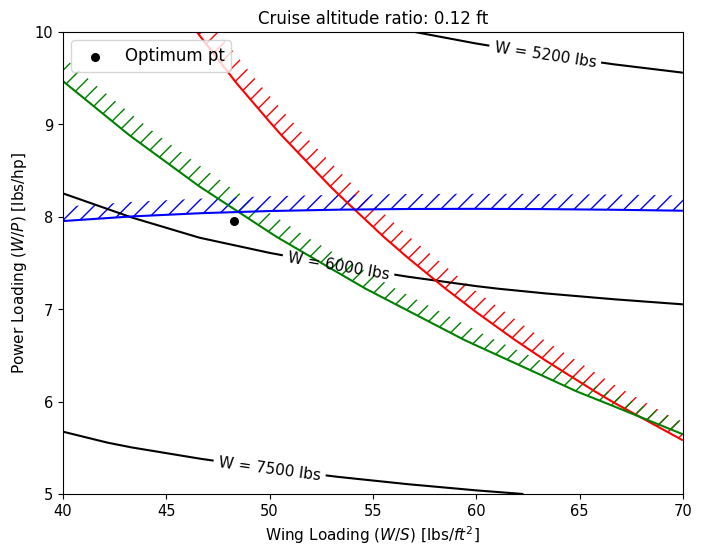

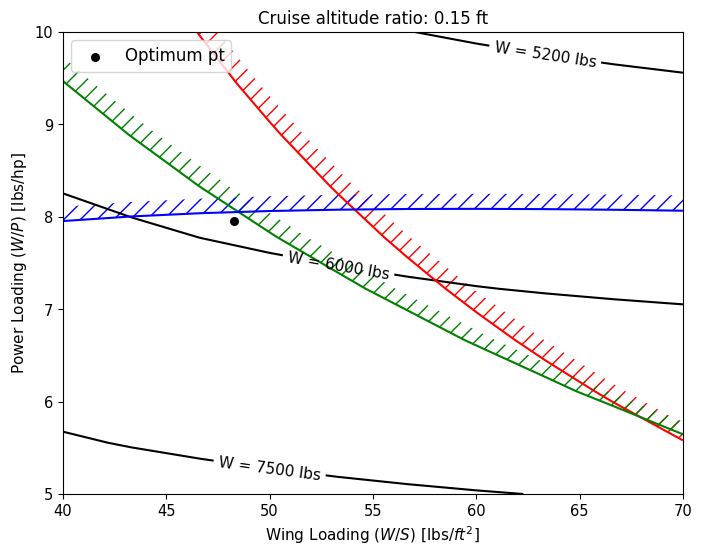

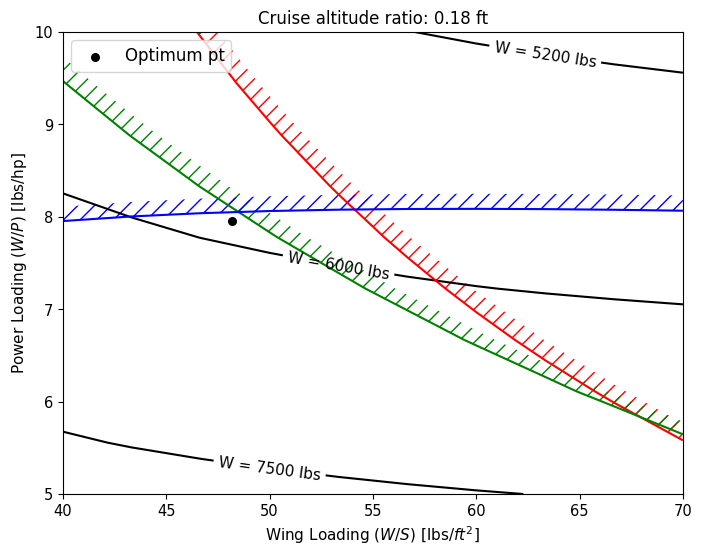

In [28]:
# A values
crusie_alt = [0.12, 0.15, 0.18]#, 0.16, 0.18]

# best_wing_loading = [43, 44, 44.5, 45.4] # lbs/sq ft
# best_power_loading = [8.6, 8.5, 8.4, 8.3] # lbs/hp

# best_wing_loading = [54.5, 55, 56, 57] # lbs/sq ft
# best_power_loading = [7.3, 7.2, 7.1, 7.0] # lbs/hp

# best_wing_loading = [54.5, 55, 56, 57, 58] # lbs/sq ft
# best_power_loading = [7.3, 7.2, 7.2, 7.1, 7.2] # lbs/hp

best_wing_loading = [48.3, 48.3, 48.2] # lbs/sq ft
best_power_loading = [7.95, 7.95, 7.95] # lbs/hp

for i, alt in enumerate(crusie_alt):
    ax = plot_trade_study(alt)
    ax.scatter(best_wing_loading[i], best_power_loading[i], color="k", s=30, label="Optimum pt")
    # ax.annotate()

    ax.legend(fontsize=12)

Below code block plots the best MTOW as the aspect ratio is varied:

In [29]:
best_mtow = []
A = 8

for WS, WP, alt in zip(best_wing_loading, best_power_loading, crusie_alt):

    mtow, _ = compute_takeoff_weight(WS, WP, A, altitude=alt)

    best_mtow.append(mtow)

print(best_mtow)

[np.float64(5896.668111730436), np.float64(5896.667001363246), np.float64(5898.661680682145)]
